<a href="https://colab.research.google.com/github/AnIsAsPe/Estadistica_y_Probabilidad_para-CD-/blob/main/Semana8/Notebooks/Red_Bayesiana_Sobrevivientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyagrum  # permite utilizar biblioteca C++ aGrUM

     |████████████████████████████████| 4.9 MB 16.0 MB/s 


In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

## Modelo bayesiano a partir de conocimiento previo

Empezamos por dibujar una red bayesiana simple, con las siguientes hipótesis:

* La unica variable que está condicionada a cada una de las demás es la sobrevivncia, las demás son independientes entre sí.
*Mujeres y niños tienen más posibilidades de sobrevivir.
* Si tienen parientes abordo, hay menos probabilidades de sobrevivencia.

In [3]:
# creamos el modelo donde todas la variable dependiente (Sobreviviencia) esta
# condicionada a las otras variables que son independientes entre ellas
bn = gum.BayesNet("Sobrevivientes")
bn =gum.fastBN("Edad{menor|adulto|mayor}<-Sobrevivencia{No|Sí}->Sexo{Mujer|Hombre};Familiares{No|Sí}<-Sobrevivencia")
print(bn.variable("Sobrevivencia"))
print(bn.variable("Edad"))
print(bn.variable("Sexo"))
print(bn.variable("Familiares"))

bn

Sobrevivencia:Labelized(<No,Sí>)
Edad:Labelized(<menor,adulto,mayor>)
Sexo:Labelized(<Mujer,Hombre>)
Familiares:Labelized(<No,Sí>)


(gum::BayesNet<double>@0x5636e6b55000) BN{nodes: 4, arcs: 3, domainSize: 24, dim: 16}

In [4]:
bn.cpt('Sobrevivencia')[:] = [1, 4]
bn.cpt('Sobrevivencia').normalizeAsCPT()
bn.cpt('Sobrevivencia')

(gum::Potential<double>@0x5636e6cb8200) 
  Sobrevivencia    |
No       |Sí      |
---------|---------|
 0.2000  | 0.8000  |

In [5]:
bn.cpt('Edad')[{'Sobrevivencia':'Sí'}] = [ 10, 5, 1]
bn.cpt('Edad')[{'Sobrevivencia':'No'}] =  [5, 10, 14]
bn.cpt('Edad').normalizeAsCPT()
bn.cpt('Edad')

(gum::Potential<double>@0x5636e6cb8140) 
      ||  Edad                       |
Sobrev||menor    |adulto   |mayor    |
------||---------|---------|---------|
No    || 0.1724  | 0.3448  | 0.4828  |
Sí   || 0.6250  | 0.3125  | 0.0625  |

In [6]:
bn.cpt('Sexo')[{'Sobrevivencia':'Sí'}] = [ 4, 1]
bn.cpt('Sexo')[{'Sobrevivencia':'No'}] = [ 1, 4]
bn.cpt('Sexo').normalizeAsCPT()
bn.cpt('Sexo')

(gum::Potential<double>@0x5636e6cb8240) 
      ||  Sexo             |
Sobrev||Mujer    |Hombre   |
------||---------|---------|
No    || 0.2000  | 0.8000  |
Sí   || 0.8000  | 0.2000  |

In [7]:
bn.cpt('Familiares')[{'Sobrevivencia':0}] = [ 1, 3]
bn.cpt('Familiares')[{'Sobrevivencia':1}] = [ 3, 1]
bn.cpt('Familiares').normalizeAsCPT()
bn.cpt('Familiares')

(gum::Potential<double>@0x5636e6cb8d20) 
      ||  Familiares       |
Sobrev||No       |Sí      |
------||---------|---------|
No    || 0.2500  | 0.7500  |
Sí   || 0.7500  | 0.2500  |

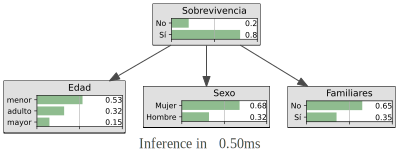

In [8]:
gnb.showInference(bn)

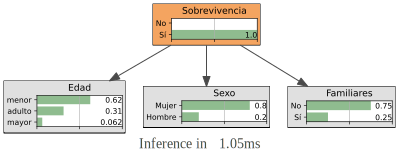

In [9]:
#¿Quiénes tienen más probabilidades de sobrevir?
gnb.showInference(bn, evs={'Sobrevivencia':'Sí'})


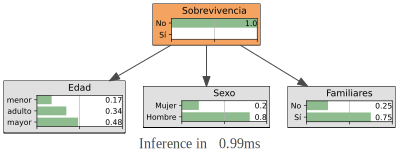

In [10]:
#¿Quiénes tienen más probabilidades de no sobrevir?
gnb.showInference(bn, evs={'Sobrevivencia':'No'})

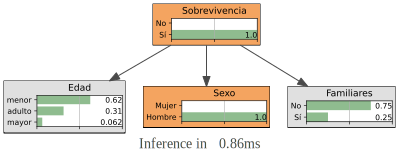

In [11]:
#los hombres que sobrevivien ¿cómo son?
gnb.showInference(bn, evs={'Sobrevivencia':'Sí', 'Sexo':'Hombre'})


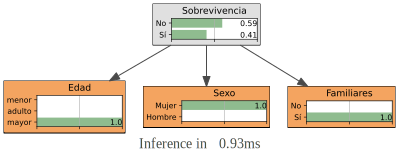

In [12]:
#¿qué pasa con las mujeres mayores?
gnb.showInference(bn,size="10", evs={'Sexo':'Mujer', 'Edad':'mayor','Familiares':'Sí'})

## Modelo bayesiano que aprende de un conjunto de datos

El conjunto de datos tiene su origen en los datos ofrecidos por [Kaggle](https://www.kaggle.com/c/titanic/data). Para llegar al conjunto presentado se unieron los datos y se hizo un preprocesmiento que incluyó selección y transformación de variables y discretización de las mismas. 



In [17]:
learner = gum.BNLearner('/content/drive/MyDrive/Datos/titanic_rb.csv')
bn = learner.learnBN()
bn

(gum::BayesNet<double>@0x5636e6dfd600) BN{nodes: 6, arcs: 8, domainSize: 576, dim: 94}

### Exploración de datos.


Podemos ver la tabla de probabilidad condicional de cada variable

In [ ]:
bn.cpt('Survived') 

(gum::Potential<double>@0x30b1440) 
             ||  Survived         |
Gender|Pclass||False    |True     |
------|------||---------|---------|
Female|1     || 0.0214  | 0.9786  |
Male  |1     || 0.7484  | 0.2516  |
Female|2     || 0.0573  | 0.9427  |
Male  |2     || 0.9002  | 0.0998  |
Female|3     || 0.3335  | 0.6665  |
Male  |3     || 0.9045  | 0.0955  |

In [ ]:
bn.cpt('Relatives')

(gum::Potential<double>@0x37fe2c0) 
      ||  Relatives        |
Age   ||False    |True     |
------||---------|---------|
adult || 0.6206  | 0.3794  |
baby  || 0.0068  | 0.9932  |
kid   || 0.0308  | 0.9692  |
old   || 0.7612  | 0.2388  |
teen  || 0.5885  | 0.4115  |
toddle|| 0.0245  | 0.9755  |

y la distribución de cada variable en nuestra base de datos

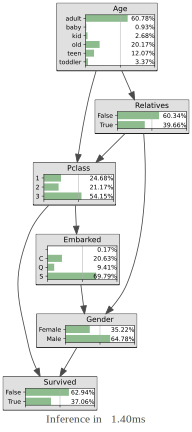

In [ ]:
gnb.showInference(bn,evs={}, size="6") 

### Calcular la probabilidad condicional según la evidencia

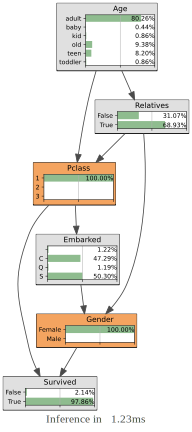

In [ ]:
gnb.showInference(bn,evs={"Gender": "Female", "Pclass": "1"}, size="6") 

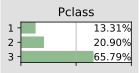

In [ ]:
#Probabilidad de la clase en la que viajan los adolecentes.
gnb.showPosterior(bn,evs={ "Age": 'teen'},target='Pclass')

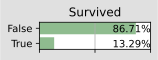

In [ ]:
# Probabilidad de sobrevivencia de los Hombres adultos:

gnb.showPosterior(bn,evs={"Gender": "Male"},target='Survived')

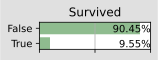

In [ ]:
# Probabilidad de sobrevivencia de los adolescentes en tercera clase:

gnb.showPosterior(bn,evs={"Gender": "Male", "Age": "teen", "Pclass": "3"},target='Survived')

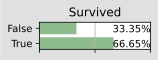

In [ ]:
#Probabilidad de sobrevivencia de las mujeres en tercera clase:
gnb.showPosterior(bn,evs={"Gender": "Female", "Pclass": "3"},target='Survived')

In [ ]:
gum.saveBN(bn, "RedBayesiana_titanic.bif")